In [1]:
import numpy as np
import random
from agent import *
from maze import *
from neural_network import *
from hrr import *
%matplotlib inline
from matplotlib import pyplot as plt

In [2]:
# Number of training cycles
episodes = 2000

# Hrr parameters
hrr_length = 5012
normalized = True

# How many steps to take before quiting
steps_till_quit = 50

# Maze parameters
size_of_maze = 5
non_obs_task_switch_rate = 12
num_non_obs_tasks = 3
num_obs_tasks = 3
goals = [[0,2,1], [1,0,2],[2,1,0]]
signals = ["red", "green", "blue"]

# random goal setting
# goals = np.stack([np.random.choice(range(size_of_maze), num_non_obs_tasks, replace=False) for _ in range(num_obs_tasks)])

# Arguments for neural network
input_size = hrr_length
output_size = 1
discount = 0.99
alpha = 0.03

# Reward for temporal difference learning
reward_bad = 0
reward_good = 1

# Expolration rate
e_soft = 0.05

# Threshold for non observable task switching
threshold = -0.1

# Print frequency
p_freq = 1

# Eligibility trace
eligibility = np.zeros(hrr_length)

# Eligibility trace rate
eli_lambda = 0.99

atr = np.random.randint(0, num_non_obs_tasks + 1)
wm = "I"

# Neural network
weights = hrr(hrr_length, normalized)
bias = 0

In [3]:
agent = agent()
maze = maze(size_of_maze, non_obs_task_switch_rate, num_non_obs_tasks, num_obs_tasks, goals)
nn = NeuralNetwork(input_size, output_size, bias, discount, alpha, reward_good, reward_bad)
ltm = LTM("hrrs_1_" + str(hrr_length), hrr_length, normalized)

In [4]:
# Pre convolve everything
for non_obs in range(num_non_obs_tasks):
    for signal in ["I"] + signals:
        for state in range(size_of_maze):
            ltm.encode("state_" + str(state) + "*non_obs_" + str(non_obs) + "*" + str(signal) + "*rewardTkn")

In [5]:
ltm.print()

non_obs_0*red*state_4 [ 0.00056361  0.01190311 -0.01240936 ...  0.01383462 -0.00238268
  0.03425955]
I*non_obs_0*rewardTkn*state_0 [-0.01078736  0.02965991  0.00385913 ...  0.01537822  0.01509718
  0.01177029]
blue*non_obs_1*rewardTkn*state_1 [ 0.00040043 -0.00885889 -0.01381742 ... -0.00851775  0.00963098
 -0.02819476]
green*state_3 [-0.00945653 -0.0209482  -0.02120528 ...  0.01774769 -0.00299115
 -0.0023009 ]
red*rewardTkn*state_2 [-0.00074235  0.01387124  0.01410669 ...  0.00264944 -0.02360589
 -0.00288194]
blue*rewardTkn*state_1 [ 0.00703818 -0.00447966  0.00491303 ...  0.00748482  0.00621641
  0.00953684]
non_obs_1*rewardTkn*state_1 [-0.00379197  0.02999192 -0.01639326 ... -0.0138558   0.01280594
  0.00386385]
green*non_obs_0*state_1 [ 0.0061243   0.0164529  -0.00680165 ...  0.0346606   0.02502737
 -0.00607831]
non_obs_1*red*rewardTkn*state_4 [-0.0074213   0.01291928  0.01337594 ... -0.01985595  0.01434433
 -0.01796157]
I*non_obs_1*rewardTkn [-0.00095825  0.00102204 -0.00748327 ..

In [6]:
def move_policy(moves, wms, non_obs, rand_on):
    
    val = -9999
    print(moves, wms, non_obs)
    
    # Random move
    if((np.random.random() < e_soft) and (rand_on == 1)):
        return np.random.choice(moves), random.choice(wms), random.choice(non_obs)
    
    # Loops through everything possibility
    for move in moves:
        for wm in wms:
            for non_ob in non_obs:
                temp = np.dot(weights, ltm.encode("state_" + str(current) + "*non_obs_" + str(non_ob) + "*" + str(signal))) + bias
                if temp > val:
                    val = temp
                    s_move = move
                    s_wm = wm
                    
    s_non_ob = non_obs[0]
    return s_move, s_wm, s_non_ob

def context_policy(atr):
    return (atr + 1)%num_non_obs_tasks

In [7]:
for x in range(episodes):
    
    # Starting state
    current = random.randint(0, size_of_maze - 1)
    
    # Signal for the maze run
    signal = np.random.choice(signals)
    print(signal)
    
    # Maze progresses
    non_obs, goal = maze.step_maze(signals.index(signal))
    
    # Reset trace
    eligibility *= 0.0
    
    wm = "I"
    
    print("Expected: Goal: " + str(goal) + " Signal: " + str(signal) + " Non_Observable: " + str(non_obs))
    
    for y in range(steps_till_quit):
        
        # Store info about previous state
        previous = current
        previous_state = ltm.encode(str(wm) + "*non_obs_" + str(atr) + "*state_" + str(previous))
        previous_value = np.dot(weights, previous_state) + bias
        
        print("Started with: State: " + str(previous) + " State Value: " + str(previous_value) + " WM: " + str(wm) + " Atr: " + str(atr))
        
        eligibility *= eli_lambda
        
        left, right = agent.get_moves(previous, size_of_maze)
        move, wm, atr = move_policy([left, right], list(set([wm, signal])), [atr], 1)
        
        # Make the move
        current = move
        current_state = ltm.encode(str(wm) + "*non_obs_" + str(atr) + "*state_" + str(current))
        current_value = np.dot(weights, current_state) + bias
        
        print("Moved: State: " + str(current) + " State Value: " + str(current_value) + " WM: " + str(wm) + " Atr: " + str(atr))
       
        # Goal reached
        if (current == goal):
            # Get temporal difference error and update weights of neural network
            goal_hrr = ltm.encode(str(wm) + "*non_obs_" + str(atr) + "*state_" + str(current) + "*rewardTkn")
            goal_value = np.dot(weights, goal_hrr) + bias
            
            error = (reward_bad + discount * goal_value - previous_value)
            eligibility = eligibility + previous_state
            weights = np.add(weights, (alpha * error * eligibility))
            
            print("In Goal: State Value: " + str(goal_value) + " WM: " + str(wm) + " Atr: " + str(atr))
     #       input("Press Enter to continue...")
            
            error = reward_good - goal_value
            eligibility = eligibility + goal_hrr
            weights = np.add(weights, (alpha * error * eligibility))
            
            break
        
        # Weight update for goal not found
        error = (reward_bad + discount * current_value) - previous_value
        eligibility = eligibility + previous_state
        if error < threshold:
                atr = context_policy(atr)
                eligibility = eligibility * 0.0
                print("Atr after policy: " + str(atr))
                
        weights = np.add(weights, (alpha * error * eligibility))
        
        signal = "I"
        
        
        
 #       input("Press Enter to continue...")
        
    if (x+1)%p_freq == 0:
        print("Episode" , x+1, "done")

red
Expected: Goal: 1 Signal: red Non_Observable: 0
Started with: State: 4 State Value: -0.02143961876409902 WM: I Atr: 3
[3, 0] ['I', 'red'] [3]
Moved: State: 3 State Value: -0.023890657764171964 WM: I Atr: 3
Started with: State: 3 State Value: -0.023891320755038137 WM: I Atr: 3
[2, 4] ['I'] [3]
Moved: State: 2 State Value: -0.0042222934129771345 WM: I Atr: 3
Started with: State: 2 State Value: -0.004222041426542964 WM: I Atr: 3
[1, 3] ['I'] [3]
Moved: State: 1 State Value: 0.003535317727632712 WM: I Atr: 3
In Goal: State Value: -0.01799059219849079 WM: I Atr: 3
Episode 1 done
red
Expected: Goal: 2 Signal: red Non_Observable: 0
Started with: State: 1 State Value: 0.00400150189149999 WM: I Atr: 3
[0, 2] ['I', 'red'] [3]
Moved: State: 0 State Value: -0.01823715632988409 WM: I Atr: 3
Started with: State: 0 State Value: -0.018234147466852764 WM: I Atr: 3
[4, 1] ['I'] [3]
Moved: State: 4 State Value: 0.00945896550228079 WM: I Atr: 3
Started with: State: 4 State Value: 0.009423464493095812 

0.9941965658697012
0.9856143419737259
0.9856143419737259
0.14081933334886823
0.14081933334886823
0.14081933334886823
0.9748025595093032
0.9748025595093032
0.9748025595093032
0.32881074857958176
0.32881074857958176
0.32881074857958176


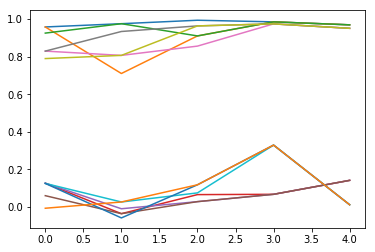

In [11]:
non_ob = 2
goals_place = 2
position = np.arange(size_of_maze)
value = np.zeros(size_of_maze)
for wm in (["I"] + signals):
    for goal in (goals[goals_place]):
        for state in range(size_of_maze):
            if(not (state == goal)):
                value[state] = np.dot(weights, ltm.encode("state_" + str(state) + "*non_obs_" + str(non_ob) + "*" + str(wm))) + bias
            else:
                value[state] = np.dot(weights, ltm.encode("state_" + str(state) + "*non_obs_" + str(non_ob) + "*" + str(wm) + "*rewardTkn")) + bias        
        plt.plot(position, value) 
        print(np.amax(value))

In [12]:
ltm.clean()
del ltm, agent, maze, nn